# Example of a simple token economy with speculators added

This is an extension of the example of a simple token economy where the pools are denominated in fiat. In this example, we will also add one more pool that is denominated in tokens. This is a pool that represents speculators, and is going to be a small part of the overall user base.



In [1]:
import numpy as np
import scipy
import os
import sys
tokenlab_path=os.path.abspath("").replace('notebooks','src')
sys.path.insert(0,tokenlab_path)

from TokenLab.simulationcomponents import *
from TokenLab.simulationcomponents.usergrowthclasses import *
from TokenLab.simulationcomponents.transactionclasses import *
from TokenLab.simulationcomponents.tokeneconomyclasses import *
from TokenLab.simulationcomponents.transactionclasses import *
from TokenLab.simulationcomponents.agentpoolclasses import *
from TokenLab.simulationcomponents.pricingclasses import *
from TokenLab.simulationcomponents.addons import AddOn_RandomNoise, AddOn_RandomNoiseProportional
from utils.helpers import *
from matplotlib import pyplot as plt

# Globals

We start by defining our globals. We choose 60 iterations, with each iteration representing 1 month, and an average holding time of 1 month. The total circulating supply is 100 million

In [2]:
ITERATIONS=60
HOLDING_TIME=1
SUPPLY=10**7
INITIAL_PRICE=0.5

# Simple token economy with fiat only

Now, let's revisit the example of a simple token economy where users simply exchange fiat for the token.

In [3]:
usm_fiat=UserGrowth_Spaced(100,54000,ITERATIONS,log_saturated_space)
tsm_fiat=TransactionManagement_Stochastic(activity_probs=np.linspace(0.25,1,ITERATIONS),
                                            value_dist_parameters={'loc':1000,'scale':200},
                                           transactions_dist_parameters={'mu':1})

ap_fiat=AgentPool_Basic(users_controller=usm_fiat,transactions_controller=tsm_fiat,currency='$')

In [4]:
usm_token=UserGrowth_Spaced(10,5400,ITERATIONS,np.linspace)
ap_token=AgentPool_Basic(users_controller=usm_token,transactions_controller=100,currency='tokenA')

100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.36it/s]


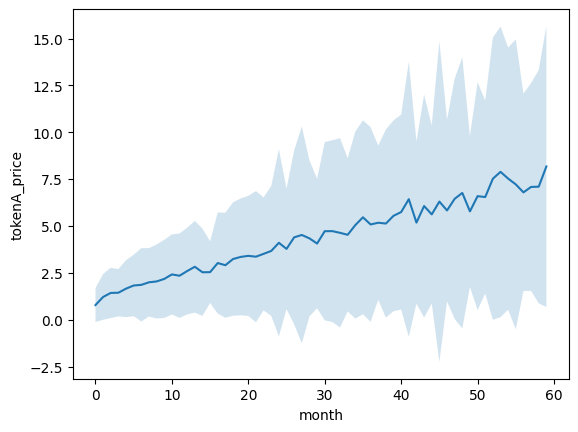

In [5]:
te=TokenEconomy_Basic(holding_time=HOLDING_TIME,supply=SUPPLY,token='tokenA',initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat,ap_token])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot

# Adding a new agent pool that transacts in tokens

Now, let's add a new agent pool that transcacts in tokens. What we observe is that the expected price has gone up. This is the result of new transactions being added

100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 27.04it/s]


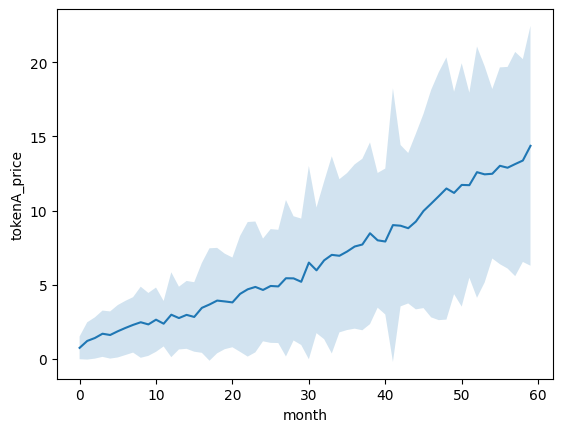

In [6]:
usm_fiat=UserGrowth_Spaced(100,54000,ITERATIONS,log_saturated_space)
tsm_fiat=TransactionManagement_Stochastic(activity_probs=np.linspace(0.25,1,ITERATIONS),
                                            value_dist_parameters={'loc':1000,'scale':200},
                                           transactions_dist_parameters={'mu':1})

ap_fiat=AgentPool_Basic(users_controller=usm_fiat,transactions_controller=tsm_fiat,currency='$')

usm_token=UserGrowth_Spaced(10,54000,ITERATIONS,np.linspace)
ap_token=AgentPool_Basic(users_controller=usm_token,transactions_controller=100,currency='tokenA')

te=TokenEconomy_Basic(holding_time=HOLDING_TIME,supply=SUPPLY,token='tokenA',initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat,ap_token])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot

# Price plus noise plus adaptive variance plus smoothing.

Now let's see whether the assumptions hold under a different pricing mechanism. In this case we will use adaptive variance plus smoothing. Smoothing applies an anchoring effect, so that the price in the next month cannot go too far from the price in the previous month.

Reminder from the original tutorial:

This is a special pricing mechanism which induces randomness in the price, but the variance of the noise is proportional to the price. The idea behind this is similar to https://www.investopedia.com/terms/g/garch.asp and has also been observed in the cryptocurrency markets. For example, this holds true for Bitcoin. The higher the value of bitcoin, the higher the observed volatility.

## Without the added agent pool

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 17.83it/s]


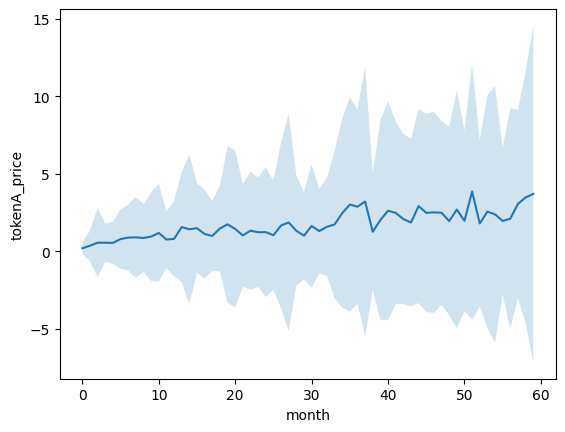

In [7]:
te=TokenEconomy_Basic(holding_time=HoldingTime_Stochastic(),supply=SUPPLY,
                      price_function=PriceFunction_EOE,token='tokenA',
                      price_function_parameters={'noise_addon':AddOn_RandomNoiseProportional(std_param=10),'smoothing_param':0.8},initial_price=INITIAL_PRICE)

te.add_agent_pools([ap_fiat])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot

In [8]:
reps['tokenA_price'].mean()

1.7348679553829534

## with the new agent pool

100%|███████████████████████████████████████████| 50/50 [00:02<00:00, 16.82it/s]


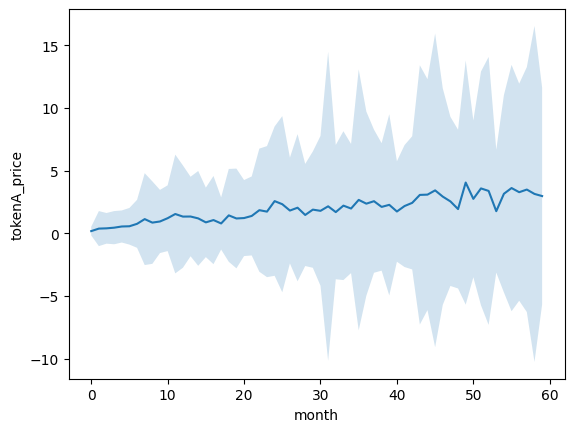

In [9]:
te=TokenEconomy_Basic(holding_time=HoldingTime_Stochastic(),supply=SUPPLY,
                      price_function=PriceFunction_EOE,token='tokenA',
                      price_function_parameters={'noise_addon':AddOn_RandomNoiseProportional(std_param=10),'smoothing_param':0.8},initial_price=INITIAL_PRICE)

te.add_agent_pools([ap_fiat,ap_token])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot

In [10]:
reps['tokenA_price'].mean()

1.9527447295443836

We see that now the average price is higher in the second case, but the difference is not as prominent, as the noise added by the pricing function dilutes the effect of the new users

# With selling pool

100%|███████████████████████████████████████████| 50/50 [00:04<00:00, 11.57it/s]


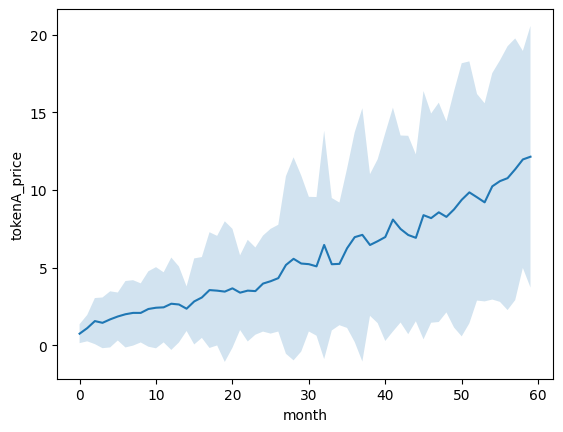

In [11]:
usm_fiat=UserGrowth_Spaced(100,54000,ITERATIONS,log_saturated_space)
tsm_fiat=TransactionManagement_Stochastic(activity_probs=np.linspace(0.25,1,ITERATIONS),
                                            value_dist_parameters={'loc':1000,'scale':200},
                                           transactions_dist_parameters={'mu':1})

ap_fiat=AgentPool_Basic(users_controller=usm_fiat,transactions_controller=tsm_fiat,currency='$')

usm_token=UserGrowth_Spaced(10,54000,ITERATIONS,np.linspace)
ap_token=AgentPool_Basic(users_controller=usm_token,transactions_controller=100,currency='tokenA')

usm_sellers=UserGrowth_Spaced(10,5400,ITERATIONS,np.linspace)
tsm_sellers=TransactionManagement_Stochastic(activity_probs=np.linspace(0.5,1,ITERATIONS),
                                            value_dist_parameters={'loc':-1000,'scale':200},
                                           transactions_dist_parameters={'mu':3},type_transaction='negative')
ap_sellers=AgentPool_Basic(users_controller=usm_sellers,transactions_controller=tsm_sellers,currency='$')


te=TokenEconomy_Basic(holding_time=HOLDING_TIME,supply=SUPPLY,token='tokenA',initial_price=INITIAL_PRICE)
te.add_agent_pools([ap_fiat,ap_token,ap_sellers])
meta=TokenMetaSimulator(te)
meta.execute(iterations=ITERATIONS,repetitions=50)
reps=meta.get_data()
plot,data=meta.get_timeseries('tokenA_price')
plot